In [ ]:
# !pip install momentfm

In [15]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from momentfm import MOMENTPipeline

import torch.optim as optim
from torch import nn
from torchmetrics import MeanSquaredError, MeanAbsoluteError

In [16]:
# Load data
df = pd.read_csv("../data/preprocessed_hourly_data.csv", parse_dates=['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

# Select features and target
features = ['Open', 'High', 'Low', 'Close', 'SMA_200', 'ATR_168']
target = 'Close'
data = df[features].values.astype(np.float32)
# data = np.log2(data + 1)

print(df.shape)
df.head()

(72666, 8)


,datetime,Timestamp,Open,High,Low,Close,SMA_200,ATR_168
0,2017-01-09 07:00:00,1.483945e+09,886.01,892.00,879.21,891.67,979.04320,19.200060
1,2017-01-09 08:00:00,1.483949e+09,891.68,891.98,884.84,888.77,978.68140,19.235417
2,2017-01-09 09:00:00,1.483952e+09,888.77,888.99,880.42,884.65,978.29765,19.273333
3,2017-01-09 10:00:00,1.483956e+09,884.65,899.56,884.65,894.41,977.95505,19.346607
4,2017-01-09 11:00:00,1.483960e+09,894.41,898.69,890.04,894.27,977.60850,19.385000


In [17]:
# Normalize features channel-wise (fit on train portion only)
n_total = len(data)
split_idx = int(0.8 * n_total)

# Create sliding windows
input_len = 512
horizon = 360 # forecast horizon, 360 hours = 15 days

windows, targets = [], []
for i in range(n_total - input_len - horizon + 1):
    inp = data[i:i+input_len, :].T  # shape: (channels, 512)
    tgt = data[i+input_len:i+input_len+horizon, features.index(target)]  # Close prices
    windows.append(inp)
    targets.append(tgt)
print(inp.shape, tgt.shape)

windows = np.stack(windows)   # shape: (N_windows, channels, input_len=512)
targets = np.stack(targets)   # shape: (N_windows, horizon=360)

print(windows.shape, targets.shape)

(6, 512) (360,)
(71795, 6, 512) (71795, 360)


In [18]:
# Split into train/val/test (chronological)
n_windows = len(windows)
print(f"Total number of windows: {n_windows}")

train_end = int(0.8 * n_windows)
val_end = int(0.9 * n_windows)
train_X, val_X, test_X = windows[:train_end], windows[train_end:val_end], windows[val_end:]
train_y, val_y, test_y = targets[:train_end], targets[train_end:val_end], targets[val_end:]

Total number of windows: 71795


In [19]:
class ForecastDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()  # shape (N, C, L): (N_windows, channels=6, input_len=512)
        self.Y = torch.from_numpy(Y).float()  # shape (N, H): (N_windows, horizon=360)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        timeseries = self.X[idx]              # (C, L)
        # print(timeseries.shape)
        forecast = self.Y[idx]               # (H,)
        input_mask = torch.ones(timeseries.shape[-1])  # (L,), all observed
        # print(input_mask.shape)
        return timeseries, forecast, input_mask


In [20]:
train_ds = ForecastDataset(train_X, train_y)
val_ds   = ForecastDataset(val_X,   val_y)
test_ds  = ForecastDataset(test_X,  test_y)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False)

In [21]:

# Load MOMENT pipeline for forecasting
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-small",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': horizon,
        # 'forecast_dim': 1,
        'head_dropout': 0.1,
        'weight_decay': 0.0,
        'freeze_encoder': True,
        'freeze_embedder': True,
        'freeze_head': False
    }
)
model.init()
# model = moment_pipe.model  # The PyTorch model with forecasting head
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\Users\4310129\AppData\Local\anaconda3\envs\AI417-DL\lib\site-packages\momentfm\models\moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=512, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (

In [ ]:
num_epochs = 50

# Loss functions
mse_loss_fn = nn.MSELoss()
huber_loss_fn = nn.SmoothL1Loss()
mse_loss_fn.to(device)
huber_loss_fn.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)

# Metrics
metric_mse = MeanSquaredError().to(device)
metric_mae = MeanAbsoluteError().to(device)

# Scheduler
from torch.optim.lr_scheduler import OneCycleLR
total_steps = len(train_loader) * num_epochs
scheduler = OneCycleLR(optimizer, max_lr=1e-3, total_steps=total_steps)
max_grad_norm = 5.0


In [23]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for series, target, mask in train_loader:
        series = series.to(device)     # (batch, L, C)
        target = target.to(device)     # (batch, H)
        mask   = mask.to(device)       # (batch, L)

        optimizer.zero_grad()
        output = model(x_enc=series, input_mask=mask)  # forward pass # shape [B, 360] from forecasting head
        # print(output.forecast.shape, target.shape)
        # loss = mse_loss_fn(output.forecast, target)
        loss = mse_loss_fn(output.forecast[:, 3, :], target)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        # scheduler.step()
        
        train_losses.append(loss.item())
    avg_train_loss = np.mean(train_losses)

    model.eval()
    val_losses = []
    metric_mse.reset(); metric_mae.reset()
    with torch.no_grad():
        for series, target, mask in val_loader:
            series = series.to(device)     # (batch, L, C)
            target = target.to(device)     # (batch, H)
            mask   = mask.to(device)       # (batch, L)

            output = model(x_enc=series, input_mask=mask)
            val_loss = huber_loss_fn(output.forecast[:, 3, :], target)
            val_losses.append(val_loss.item())
            preds = output.forecast[:, 3, :].contiguous()
            metric_mse(preds, target)
            metric_mae(preds, target)
    avg_val_loss = np.mean(val_losses)
    val_mse = metric_mse.compute().item()
    val_mae = metric_mae.compute().item()

    print(f"Epoch {epoch+1} | Train Loss {avg_train_loss:.4f} | Val Loss {avg_val_loss:.4f}  | Val MSE {val_mse:.4f}, Val MAE {val_mae:.4f}")

c:\Users\4310129\AppData\Local\anaconda3\envs\AI417-DL\lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\4310129\AppData\Local\anaconda3\envs\AI417-DL\lib\site-packages\torch\utils\checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1 | Train Loss 7251805.3917 | Val Loss 2520.7901  | Val MSE 13548272.0000, Val MAE 2520.4963
Epoch 2 | Train Loss 6605083.3149 | Val Loss 2562.2420  | Val MSE 13787788.0000, Val MAE 2562.0317
Epoch 3 | Train Loss 6333807.2687 | Val Loss 2601.1272  | Val MSE 14012710.0000, Val MAE 2600.9749
Epoch 4 | Train Loss 6156141.8997 | Val Loss 2629.7925  | Val MSE 14518103.0000, Val MAE 2629.7764
Epoch 5 | Train Loss 6006468.0115 | Val Loss 2633.5147  | Val MSE 14391007.0000, Val MAE 2633.4150
Epoch 6 | Train Loss 5866773.9225 | Val Loss 2619.7722  | Val MSE 14360980.0000, Val MAE 2619.4861
Epoch 7 | Train Loss 5782399.9755 | Val Loss 2630.6125  | Val MSE 14275199.0000, Val MAE 2630.5166
Epoch 8 | Train Loss 5675613.1404 | Val Loss 2645.9644  | Val MSE 14429813.0000, Val MAE 2645.8313
Epoch 9 | Train Loss 5596783.4570 | Val Loss 2660.5183  | Val MSE 14547211.0000, Val MAE 2660.4226
Epoch 10 | Train Loss 5522276.1670 | Val Loss 2677.6350  | Val MSE 14926924.0000, Val MAE 2677.5269
Epoch 11 

In [36]:
model.eval()
test_losses = []
metric_mse.reset(); metric_mae.reset()
predicted_values = []
target_values = []
with torch.no_grad():
    for series, target, mask in test_loader:
        series, target, mask = series.to(device), target.to(device), mask.to(device)
        output = model(x_enc=series, input_mask=mask)

        preds = output.forecast[:, 3, :].contiguous()
        metric_mse(preds, target)
        metric_mae(preds, target)
        
        predicted_values = preds[-1].cpu()
        target_values = target[-1].cpu()
        
        # For reporting Huber:
        test_losses.append(huber_loss_fn(output.forecast[:, 3, :], target).item())
test_mse = metric_mse.compute().item()
test_mae = metric_mae.compute().item()
test_huber = np.mean(test_losses)

print(f"Test MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}, Test Huber: {test_huber:.4f}")


Test MSE: 33025484.0000, Test MAE: 4133.3789, Test Huber: 4135.6342


In [37]:
print(predicted_values.shape, target_values.shape)

torch.Size([360]) torch.Size([360])


In [38]:
import matplotlib.pyplot as plt

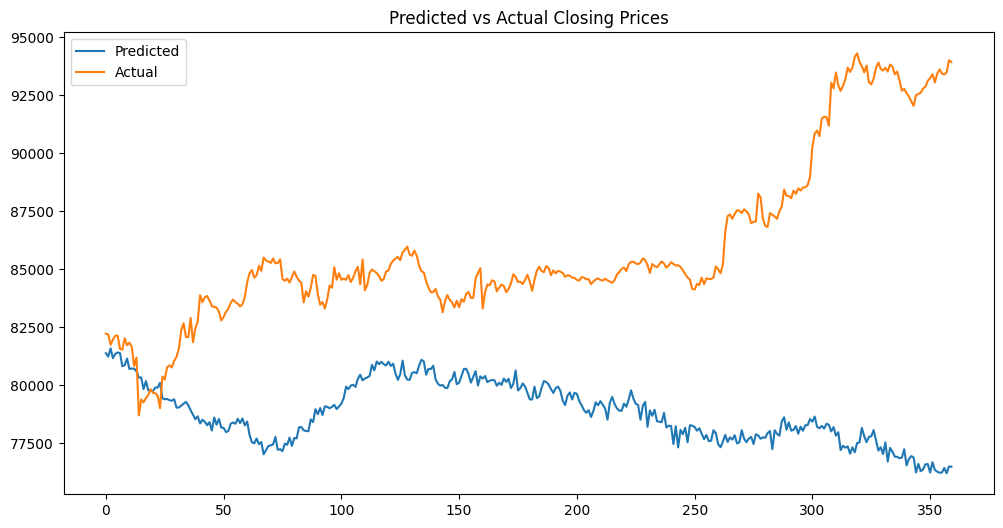

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(predicted_values, label='Predicted')
plt.plot(target_values, label='Actual')
plt.title('Predicted vs Actual Closing Prices')
plt.legend()
plt.show()